In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from utils import get_hessian_eigenvalues, get_hessian_trace

## DLN Setup

In [11]:
class DiagonalDeepMatrixFactorization(nn.Module):
    def __init__(self, d, depth, init_scale=1e-2):
        super(DiagonalDeepMatrixFactorization, self).__init__()

        self.factors = nn.ParameterList([nn.Parameter(torch.zeros(d, d))] # one zero initialization
                                        + [torch.nn.init.eye_(torch.empty(d, d))*init_scale for _ in range(depth-1)]) # others are diagonal

        # self.factors = nn.ParameterList(
        #                                 [torch.nn.init.eye_(torch.empty(d, d))*init_scale for _ in range(depth)])
    def forward(self):
        product = self.factors[0]
        for i in range(1, len(self.factors)):
            product = product @ self.factors[i]
        return product


class AllDiagonalDeepMatrixFactorization(nn.Module):
    def __init__(self, d, depth, init_scale=1e-2):
        super(AllDiagonalDeepMatrixFactorization, self).__init__()

        # self.factors = nn.ParameterList([torch.nn.init.eye_(torch.empty(d, d))*init_scale for _ in range(depth)]) # all are diagonal

        # self.factors = nn.ParameterList(
        #                                 [torch.nn.init.eye_(torch.empty(d, d))*init_scale for _ in range(depth)])
    def forward(self):
        product = self.factors[0]
        for i in range(1, len(self.factors)):
            product = product @ self.factors[i]
        return product

class AllOrthogonalDeepMatrixFactorization(nn.Module):
    """
    Setup for deep matrix factorization with one zero initialization and rest orthogonal.
    """

    def __init__(self, d, depth, init_scale=1e-2):
        super(AllOrthogonalDeepMatrixFactorization, self).__init__()

        self.factors = nn.ParameterList([torch.nn.init.orthogonal_(torch.empty(d, d), gain=init_scale) for _ in range(depth)]) # others are orthogonal
        # init = torch.nn.init.orthogonal_(torch.empty(d, d), gain=init_scale)

    def forward(self):
        product = self.factors[0]
        for i in range(1, len(self.factors)):
            product = product @ self.factors[i]
        return product

In [3]:
def train_gd(step_size,
              n_outer_loops,
              n_inner_loops,
              tol,
              model,
              target,
              batch_size=None,
              callback=None):
    
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size, weight_decay=0.0)

    test_losses = []
    train_losses = []
    weights_list = []
        
    pbar = tqdm(range(n_outer_loops))

    for itr in pbar:
        for _ in range(n_inner_loops):
            # Update
            optimizer.zero_grad()
                
            train_loss = criterion(model(), target)

            train_loss.backward()
            optimizer.step()
    
        test_loss = criterion(model(), target)
        test_losses.append( test_loss.detach().numpy() )
        
        if train_loss < tol:
            break
                
        if callback:
            callback(itr=itr, model=model, target=target)
    
        pbar.set_description(f"Train loss: {train_loss:0.2e}, test loss: {test_loss:0.2e}")
        weights_list.append( deepcopy(model) )

    result_dict = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'weights': weights_list,
        'final_weights': deepcopy(model)
    }
    
    return result_dict



## Generate Data

In [4]:
def generate_data(shape, rank):
    mat = torch.randn(shape)
    
    if rank is not None:
        U, S, V = torch.svd( mat )
        
    return U[:, :rank] @ torch.diag(S[:rank]) @ V[:, :rank].T

In [13]:
d = 100
r = 3

target = generate_data(shape=(d,d), rank=r)
u, s, v = torch.svd(target)

s[0] = 10
s[1] = 8
s[2] = 6

target = u @ torch.diag(s) @ v.T

## Training DLN

In [14]:
# Parameters
depth = 3
tol = 0
n_outer_loops = 500
n_inner_loops = 1
step_size = 0.01
init_scale = 1.0

sharpness1 = []

model = DiagonalDeepMatrixFactorization(d=d, depth=depth, init_scale=init_scale)
criterion = torch.nn.MSELoss(reduction='sum')

def callback(itr, model, target):
    loss = criterion(model(), target)
    
    if itr % 5 == 0:
        sharpness1.append( get_hessian_eigenvalues(model=model, loss_fn=loss, neigs=2)[0] )

    print('Sharpness:', sharpness1[-1])


# Train model
gd_result = train_gd(
                step_size=step_size,
                n_outer_loops=n_outer_loops,
                n_inner_loops=n_inner_loops,
                tol=tol,
                model=model,
                target=target,
                callback=callback           
)






  0%|                                                                                                                                                                                     | 0/500 [00:00<?, ?it/s]



Train loss: 2.00e+02, test loss: 1.92e+02:   0%|                                                                                                                                          | 0/500 [00:23<?, ?it/s]



Train loss: 2.00e+02, test loss: 1.92e+02:   0%|▎                                                                                                                               | 1/500 [00:23<3:13:02, 23.21s/it]

Sharpness: tensor(29.5326)






Train loss: 1.92e+02, test loss: 1.84e+02:   0%|▎                                                                                                                               | 1/500 [00:23<3:13:02, 23.21s/it]



Train loss: 1.92e+02, test loss: 1.84e+02:   0%|▌                                                                                                                               | 2/500 [00:23<2:15:38, 16.34s/it]

Sharpness: tensor(29.5326)






Train loss: 1.84e+02, test loss: 1.72e+02:   0%|▌                                                                                                                               | 2/500 [00:23<2:15:38, 16.34s/it]



Train loss: 1.84e+02, test loss: 1.72e+02:   1%|▊                                                                                                                               | 3/500 [00:23<1:35:30, 11.53s/it]

Sharpness: tensor(29.5326)






Train loss: 1.72e+02, test loss: 1.56e+02:   1%|▊                                                                                                                               | 3/500 [00:24<1:35:30, 11.53s/it]



Train loss: 1.72e+02, test loss: 1.56e+02:   1%|█                                                                                                                               | 4/500 [00:24<1:07:19,  8.14s/it]

Sharpness: tensor(29.5326)






Train loss: 1.56e+02, test loss: 1.32e+02:   1%|█                                                                                                                               | 4/500 [00:24<1:07:19,  8.14s/it]



Train loss: 1.56e+02, test loss: 1.32e+02:   1%|█▎                                                                                                                                | 5/500 [00:24<47:36,  5.77s/it]

Sharpness: tensor(29.5326)






Train loss: 1.32e+02, test loss: 9.62e+01:   1%|█▎                                                                                                                                | 5/500 [00:42<47:36,  5.77s/it]



Train loss: 1.32e+02, test loss: 9.62e+01:   1%|█▌                                                                                                                              | 6/500 [00:42<1:17:18,  9.39s/it]

Sharpness: tensor(60.3175)






Train loss: 9.62e+01, test loss: 5.45e+01:   1%|█▌                                                                                                                              | 6/500 [00:42<1:17:18,  9.39s/it]



Train loss: 9.62e+01, test loss: 5.45e+01:   1%|█▊                                                                                                                                | 7/500 [00:42<54:54,  6.68s/it]

Sharpness: tensor(60.3175)






Train loss: 5.45e+01, test loss: 2.64e+01:   1%|█▊                                                                                                                                | 7/500 [00:42<54:54,  6.68s/it]



Train loss: 5.45e+01, test loss: 2.64e+01:   2%|██                                                                                                                                | 8/500 [00:42<39:12,  4.78s/it]

Sharpness: tensor(60.3175)






Train loss: 2.64e+01, test loss: 1.28e+01:   2%|██                                                                                                                                | 8/500 [00:43<39:12,  4.78s/it]



Train loss: 2.64e+01, test loss: 1.28e+01:   2%|██▎                                                                                                                               | 9/500 [00:43<28:13,  3.45s/it]

Sharpness: tensor(60.3175)






Train loss: 1.28e+01, test loss: 5.88e+00:   2%|██▎                                                                                                                               | 9/500 [00:43<28:13,  3.45s/it]



Train loss: 1.28e+01, test loss: 5.88e+00:   2%|██▌                                                                                                                              | 10/500 [00:43<20:30,  2.51s/it]

Sharpness: tensor(60.3175)






Train loss: 5.88e+00, test loss: 2.35e+00:   2%|██▌                                                                                                                              | 10/500 [01:04<20:30,  2.51s/it]



Train loss: 5.88e+00, test loss: 2.35e+00:   2%|██▊                                                                                                                            | 11/500 [01:04<1:05:38,  8.05s/it]

Sharpness: tensor(129.9038)






Train loss: 2.35e+00, test loss: 6.59e-01:   2%|██▊                                                                                                                            | 11/500 [01:04<1:05:38,  8.05s/it]



Train loss: 2.35e+00, test loss: 6.59e-01:   2%|███                                                                                                                              | 12/500 [01:04<46:40,  5.74s/it]

Sharpness: tensor(129.9038)






Train loss: 6.59e-01, test loss: 1.28e-01:   2%|███                                                                                                                              | 12/500 [01:05<46:40,  5.74s/it]



Train loss: 6.59e-01, test loss: 1.28e-01:   3%|███▎                                                                                                                             | 13/500 [01:05<33:16,  4.10s/it]

Sharpness: tensor(129.9038)






Train loss: 1.28e-01, test loss: 1.88e-02:   3%|███▎                                                                                                                             | 13/500 [01:05<33:16,  4.10s/it]



Train loss: 1.28e-01, test loss: 1.88e-02:   3%|███▌                                                                                                                             | 14/500 [01:05<23:50,  2.94s/it]

Sharpness: tensor(129.9038)






Train loss: 1.88e-02, test loss: 2.39e-03:   3%|███▌                                                                                                                             | 14/500 [01:05<23:50,  2.94s/it]



Train loss: 1.88e-02, test loss: 2.39e-03:   3%|███▊                                                                                                                             | 15/500 [01:05<17:25,  2.16s/it]

Sharpness: tensor(129.9038)






Train loss: 2.39e-03, test loss: 2.87e-04:   3%|███▊                                                                                                                             | 15/500 [01:15<17:25,  2.16s/it]



Train loss: 2.39e-03, test loss: 2.87e-04:   3%|████▏                                                                                                                            | 16/500 [01:15<35:32,  4.41s/it]

Sharpness: tensor(129.6415)






Train loss: 2.87e-04, test loss: 3.36e-05:   3%|████▏                                                                                                                            | 16/500 [01:15<35:32,  4.41s/it]



Train loss: 2.87e-04, test loss: 3.36e-05:   3%|████▍                                                                                                                            | 17/500 [01:15<25:31,  3.17s/it]

Sharpness: tensor(129.6415)






Train loss: 3.36e-05, test loss: 3.91e-06:   3%|████▍                                                                                                                            | 17/500 [01:15<25:31,  3.17s/it]



Train loss: 3.36e-05, test loss: 3.91e-06:   4%|████▋                                                                                                                            | 18/500 [01:15<18:27,  2.30s/it]

Sharpness: tensor(129.6415)






Train loss: 3.91e-06, test loss: 4.53e-07:   4%|████▋                                                                                                                            | 18/500 [01:16<18:27,  2.30s/it]



Train loss: 3.91e-06, test loss: 4.53e-07:   4%|████▉                                                                                                                            | 19/500 [01:16<13:44,  1.71s/it]

Sharpness: tensor(129.6415)






Train loss: 4.53e-07, test loss: 5.26e-08:   4%|████▉                                                                                                                            | 19/500 [01:16<13:44,  1.71s/it]



Train loss: 4.53e-07, test loss: 5.26e-08:   4%|█████▏                                                                                                                           | 20/500 [01:16<10:21,  1.30s/it]

Sharpness: tensor(129.6415)






Train loss: 5.26e-08, test loss: 6.22e-09:   4%|█████▏                                                                                                                           | 20/500 [01:27<10:21,  1.30s/it]



Train loss: 5.26e-08, test loss: 6.22e-09:   4%|█████▍                                                                                                                           | 21/500 [01:27<32:19,  4.05s/it]

Sharpness: tensor(129.6421)






Train loss: 6.22e-09, test loss: 8.31e-10:   4%|█████▍                                                                                                                           | 21/500 [01:27<32:19,  4.05s/it]



Train loss: 6.22e-09, test loss: 8.31e-10:   4%|█████▋                                                                                                                           | 22/500 [01:27<23:25,  2.94s/it]



Train loss: 8.31e-10, test loss: 2.00e-10:   4%|█████▋                                                                                                                           | 22/500 [01:27<23:25,  2.94s/it]



Train loss: 8.31e-10, test loss: 2.00e-10:   5%|█████▉                                                                                                                           | 23/500 [01:27<16:48,  2.11s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 2.00e-10, test loss: 1.23e-10:   5%|█████▉                                                                                                                           | 23/500 [01:27<16:48,  2.11s/it]



Train loss: 2.00e-10, test loss: 1.23e-10:   5%|██████▏                                                                                                                          | 24/500 [01:27<12:14,  1.54s/it]

Sharpness: tensor(129.6421)






Train loss: 1.23e-10, test loss: 1.10e-10:   5%|██████▏                                                                                                                          | 24/500 [01:28<12:14,  1.54s/it]



Train loss: 1.23e-10, test loss: 1.10e-10:   5%|██████▍                                                                                                                          | 25/500 [01:28<09:12,  1.16s/it]

Sharpness: tensor(129.6421)






Train loss: 1.10e-10, test loss: 1.04e-10:   5%|██████▍                                                                                                                          | 25/500 [01:38<09:12,  1.16s/it]



Train loss: 1.10e-10, test loss: 1.04e-10:   5%|██████▋                                                                                                                          | 26/500 [01:38<30:17,  3.83s/it]

Sharpness: tensor(129.6421)






Train loss: 1.04e-10, test loss: 1.00e-10:   5%|██████▋                                                                                                                          | 26/500 [01:38<30:17,  3.83s/it]



Train loss: 1.04e-10, test loss: 1.00e-10:   5%|██████▉                                                                                                                          | 27/500 [01:38<21:44,  2.76s/it]

Sharpness: tensor(129.6421)






Train loss: 1.00e-10, test loss: 9.60e-11:   5%|██████▉                                                                                                                          | 27/500 [01:38<21:44,  2.76s/it]



Train loss: 1.00e-10, test loss: 9.60e-11:   6%|███████▏                                                                                                                         | 28/500 [01:38<15:53,  2.02s/it]

Sharpness: tensor(129.6421)






Train loss: 9.60e-11, test loss: 9.23e-11:   6%|███████▏                                                                                                                         | 28/500 [01:38<15:53,  2.02s/it]



Train loss: 9.60e-11, test loss: 9.23e-11:   6%|███████▍                                                                                                                         | 29/500 [01:38<11:46,  1.50s/it]



Train loss: 9.23e-11, test loss: 8.87e-11:   6%|███████▍                                                                                                                         | 29/500 [01:39<11:46,  1.50s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 8.87e-11, test loss: 8.55e-11:   6%|███████▍                                                                                                                         | 29/500 [01:50<11:46,  1.50s/it]



Train loss: 8.87e-11, test loss: 8.55e-11:   6%|███████▉                                                                                                                         | 31/500 [01:50<21:47,  2.79s/it]

Sharpness: tensor(129.6421)






Train loss: 8.55e-11, test loss: 8.23e-11:   6%|███████▉                                                                                                                         | 31/500 [01:50<21:47,  2.79s/it]



Train loss: 8.55e-11, test loss: 8.23e-11:   6%|████████▎                                                                                                                        | 32/500 [01:50<16:03,  2.06s/it]

Sharpness: tensor(129.6421)






Train loss: 8.23e-11, test loss: 7.91e-11:   6%|████████▎                                                                                                                        | 32/500 [01:51<16:03,  2.06s/it]



Train loss: 8.23e-11, test loss: 7.91e-11:   7%|████████▌                                                                                                                        | 33/500 [01:51<12:03,  1.55s/it]

Sharpness: tensor(129.6421)






Train loss: 7.91e-11, test loss: 7.63e-11:   7%|████████▌                                                                                                                        | 33/500 [01:51<12:03,  1.55s/it]



Train loss: 7.91e-11, test loss: 7.63e-11:   7%|████████▊                                                                                                                        | 34/500 [01:51<09:05,  1.17s/it]

Sharpness: tensor(129.6421)






Train loss: 7.63e-11, test loss: 7.35e-11:   7%|████████▊                                                                                                                        | 34/500 [01:51<09:05,  1.17s/it]



Train loss: 7.63e-11, test loss: 7.35e-11:   7%|█████████                                                                                                                        | 35/500 [01:51<07:00,  1.11it/s]

Sharpness: tensor(129.6421)






Train loss: 7.35e-11, test loss: 7.08e-11:   7%|█████████                                                                                                                        | 35/500 [02:02<07:00,  1.11it/s]



Train loss: 7.35e-11, test loss: 7.08e-11:   7%|█████████▎                                                                                                                       | 36/500 [02:02<28:50,  3.73s/it]



Train loss: 7.08e-11, test loss: 6.83e-11:   7%|█████████▎                                                                                                                       | 36/500 [02:02<28:50,  3.73s/it]



Train loss: 7.08e-11, test loss: 6.83e-11:   7%|█████████▌                                                                                                                       | 37/500 [02:02<20:34,  2.67s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 6.83e-11, test loss: 6.61e-11:   7%|█████████▌                                                                                                                       | 37/500 [02:02<20:34,  2.67s/it]



Train loss: 6.83e-11, test loss: 6.61e-11:   8%|█████████▊                                                                                                                       | 38/500 [02:02<14:41,  1.91s/it]



Train loss: 6.61e-11, test loss: 6.37e-11:   8%|█████████▊                                                                                                                       | 38/500 [02:02<14:41,  1.91s/it]



Train loss: 6.61e-11, test loss: 6.37e-11:   8%|██████████                                                                                                                       | 39/500 [02:02<10:34,  1.38s/it]



Train loss: 6.37e-11, test loss: 6.17e-11:   8%|██████████                                                                                  

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 6.17e-11, test loss: 5.96e-11:   8%|██████████                                                                                                                       | 39/500 [02:12<10:34,  1.38s/it]



Train loss: 6.17e-11, test loss: 5.96e-11:   8%|██████████▌                                                                                                                      | 41/500 [02:12<18:56,  2.48s/it]



Train loss: 5.96e-11, test loss: 5.77e-11:   8%|██████████▌                                                                                                                      | 41/500 [02:12<18:56,  2.48s/it]



Train loss: 5.77e-11, test loss: 5.57e-11:   8%|██████████▌                                                                                                                      | 41/500 [02:12<18:56,  2.48s/it]



Train loss: 5.57e-11, test loss: 5.38e-11:   8%|██████████▌                                                                                 

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 5.20e-11, test loss: 5.04e-11:   8%|██████████▌                                                                                                                      | 41/500 [02:23<18:56,  2.48s/it]



Train loss: 5.20e-11, test loss: 5.04e-11:   9%|███████████▊                                                                                                                     | 46/500 [02:23<17:51,  2.36s/it]

Sharpness: tensor(129.6421)






Train loss: 5.04e-11, test loss: 4.88e-11:   9%|███████████▊                                                                                                                     | 46/500 [02:23<17:51,  2.36s/it]



Train loss: 5.04e-11, test loss: 4.88e-11:   9%|████████████▏                                                                                                                    | 47/500 [02:23<13:10,  1.75s/it]

Sharpness: tensor(129.6421)






Train loss: 4.88e-11, test loss: 4.73e-11:   9%|████████████▏                                                                                                                    | 47/500 [02:23<13:10,  1.75s/it]



Train loss: 4.88e-11, test loss: 4.73e-11:  10%|████████████▍                                                                                                                    | 48/500 [02:23<09:52,  1.31s/it]

Sharpness: tensor(129.6421)






Train loss: 4.73e-11, test loss: 4.59e-11:  10%|████████████▍                                                                                                                    | 48/500 [02:24<09:52,  1.31s/it]



Train loss: 4.73e-11, test loss: 4.59e-11:  10%|████████████▋                                                                                                                    | 49/500 [02:24<07:38,  1.02s/it]

Sharpness: tensor(129.6421)






Train loss: 4.59e-11, test loss: 4.45e-11:  10%|████████████▋                                                                                                                    | 49/500 [02:24<07:38,  1.02s/it]



Train loss: 4.59e-11, test loss: 4.45e-11:  10%|████████████▉                                                                                                                    | 50/500 [02:24<06:08,  1.22it/s]

Sharpness: tensor(129.6421)






Train loss: 4.45e-11, test loss: 4.33e-11:  10%|████████████▉                                                                                                                    | 50/500 [02:35<06:08,  1.22it/s]



Train loss: 4.45e-11, test loss: 4.33e-11:  10%|█████████████▏                                                                                                                   | 51/500 [02:35<28:32,  3.82s/it]



Train loss: 4.33e-11, test loss: 4.21e-11:  10%|█████████████▏                                                                                                                   | 51/500 [02:35<28:32,  3.82s/it]



Train loss: 4.33e-11, test loss: 4.21e-11:  10%|█████████████▍                                                                                                                   | 52/500 [02:35<20:11,  2.70s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 4.21e-11, test loss: 4.08e-11:  10%|█████████████▍                                                                                                                   | 52/500 [02:35<20:11,  2.70s/it]



Train loss: 4.21e-11, test loss: 4.08e-11:  11%|█████████████▋                                                                                                                   | 53/500 [02:35<14:42,  1.98s/it]

Sharpness: tensor(129.6421)






Train loss: 4.08e-11, test loss: 3.98e-11:  11%|█████████████▋                                                                                                                   | 53/500 [02:35<14:42,  1.98s/it]



Train loss: 4.08e-11, test loss: 3.98e-11:  11%|█████████████▉                                                                                                                   | 54/500 [02:35<11:03,  1.49s/it]

Sharpness: tensor(129.6421)






Train loss: 3.98e-11, test loss: 3.85e-11:  11%|█████████████▉                                                                                                                   | 54/500 [02:36<11:03,  1.49s/it]



Train loss: 3.98e-11, test loss: 3.85e-11:  11%|██████████████▏                                                                                                                  | 55/500 [02:36<08:25,  1.14s/it]

Sharpness: tensor(129.6421)






Train loss: 3.85e-11, test loss: 3.74e-11:  11%|██████████████▏                                                                                                                  | 55/500 [02:47<08:25,  1.14s/it]



Train loss: 3.85e-11, test loss: 3.74e-11:  11%|██████████████▍                                                                                                                  | 56/500 [02:47<30:34,  4.13s/it]

Sharpness: tensor(129.6421)






Train loss: 3.74e-11, test loss: 3.66e-11:  11%|██████████████▍                                                                                                                  | 56/500 [02:47<30:34,  4.13s/it]



Train loss: 3.74e-11, test loss: 3.66e-11:  11%|██████████████▋                                                                                                                  | 57/500 [02:47<21:53,  2.96s/it]

Sharpness: tensor(129.6421)






Train loss: 3.66e-11, test loss: 3.55e-11:  11%|██████████████▋                                                                                                                  | 57/500 [02:47<21:53,  2.96s/it]



Train loss: 3.66e-11, test loss: 3.55e-11:  12%|██████████████▉                                                                                                                  | 58/500 [02:47<15:55,  2.16s/it]

Sharpness: tensor(129.6421)






Train loss: 3.55e-11, test loss: 3.47e-11:  12%|██████████████▉                                                                                                                  | 58/500 [02:48<15:55,  2.16s/it]



Train loss: 3.55e-11, test loss: 3.47e-11:  12%|███████████████▏                                                                                                                 | 59/500 [02:48<11:49,  1.61s/it]

Sharpness: tensor(129.6421)






Train loss: 3.47e-11, test loss: 3.37e-11:  12%|███████████████▏                                                                                                                 | 59/500 [02:48<11:49,  1.61s/it]



Train loss: 3.47e-11, test loss: 3.37e-11:  12%|███████████████▍                                                                                                                 | 60/500 [02:48<08:55,  1.22s/it]

Sharpness: tensor(129.6421)






Train loss: 3.37e-11, test loss: 3.30e-11:  12%|███████████████▍                                                                                                                 | 60/500 [02:56<08:55,  1.22s/it]



Train loss: 3.37e-11, test loss: 3.30e-11:  12%|███████████████▋                                                                                                                 | 61/500 [02:56<22:51,  3.12s/it]

Sharpness: tensor(129.6421)






Train loss: 3.30e-11, test loss: 3.21e-11:  12%|███████████████▋                                                                                                                 | 61/500 [02:56<22:51,  3.12s/it]



Train loss: 3.30e-11, test loss: 3.21e-11:  12%|███████████████▉                                                                                                                 | 62/500 [02:56<16:25,  2.25s/it]

Sharpness: tensor(129.6421)






Train loss: 3.21e-11, test loss: 3.14e-11:  12%|███████████████▉                                                                                                                 | 62/500 [02:56<16:25,  2.25s/it]



Train loss: 3.21e-11, test loss: 3.14e-11:  13%|████████████████▎                                                                                                                | 63/500 [02:56<11:56,  1.64s/it]



Train loss: 3.14e-11, test loss: 3.07e-11:  13%|████████████████▎                                                                                                                | 63/500 [02:56<11:56,  1.64s/it]



Train loss: 3.14e-11, test loss: 3.07e-11:  13%|████████████████▌                                                                                                                | 64/500 [02:56<08:45,  1.21s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 3.07e-11, test loss: 2.99e-11:  13%|████████████████▌                                                                                                                | 64/500 [02:56<08:45,  1.21s/it]



Train loss: 3.07e-11, test loss: 2.99e-11:  13%|████████████████▊                                                                                                                | 65/500 [02:56<06:25,  1.13it/s]

Sharpness: tensor(129.6421)






Train loss: 2.99e-11, test loss: 2.91e-11:  13%|████████████████▊                                                                                                                | 65/500 [03:04<06:25,  1.13it/s]



Train loss: 2.99e-11, test loss: 2.91e-11:  13%|█████████████████                                                                                                                | 66/500 [03:04<20:31,  2.84s/it]

Sharpness: tensor(129.6421)






Train loss: 2.91e-11, test loss: 2.83e-11:  13%|█████████████████                                                                                                                | 66/500 [03:04<20:31,  2.84s/it]



Train loss: 2.91e-11, test loss: 2.83e-11:  13%|█████████████████▎                                                                                                               | 67/500 [03:04<14:58,  2.07s/it]



Train loss: 2.83e-11, test loss: 2.77e-11:  13%|█████████████████▎                                                                                                               | 67/500 [03:04<14:58,  2.07s/it]



Train loss: 2.77e-11, test loss: 2.72e-11:  13%|█████████████████▎                                                                                                               | 67/500 [03:04<14:58,  2.07s/it]



Train loss: 2.72e-11, test loss: 2.66e-11:  13%|█████████████████▎                                                                          

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 2.66e-11, test loss: 2.60e-11:  13%|█████████████████▎                                                                                                               | 67/500 [03:12<14:58,  2.07s/it]



Train loss: 2.66e-11, test loss: 2.60e-11:  14%|██████████████████▎                                                                                                              | 71/500 [03:12<14:44,  2.06s/it]

Sharpness: tensor(129.6421)






Train loss: 2.60e-11, test loss: 2.54e-11:  14%|██████████████████▎                                                                                                              | 71/500 [03:13<14:44,  2.06s/it]



Train loss: 2.60e-11, test loss: 2.54e-11:  14%|██████████████████▌                                                                                                              | 72/500 [03:13<10:55,  1.53s/it]

Sharpness: tensor(129.6421)






Train loss: 2.54e-11, test loss: 2.50e-11:  14%|██████████████████▌                                                                                                              | 72/500 [03:13<10:55,  1.53s/it]



Train loss: 2.54e-11, test loss: 2.50e-11:  15%|██████████████████▊                                                                                                              | 73/500 [03:13<08:14,  1.16s/it]

Sharpness: tensor(129.6421)






Train loss: 2.50e-11, test loss: 2.46e-11:  15%|██████████████████▊                                                                                                              | 73/500 [03:13<08:14,  1.16s/it]



Train loss: 2.50e-11, test loss: 2.46e-11:  15%|███████████████████                                                                                                              | 74/500 [03:13<06:15,  1.13it/s]

Sharpness: tensor(129.6421)






Train loss: 2.46e-11, test loss: 2.41e-11:  15%|███████████████████                                                                                                              | 74/500 [03:13<06:15,  1.13it/s]



Train loss: 2.46e-11, test loss: 2.41e-11:  15%|███████████████████▎                                                                                                             | 75/500 [03:13<04:51,  1.46it/s]

Sharpness: tensor(129.6421)






Train loss: 2.41e-11, test loss: 2.36e-11:  15%|███████████████████▎                                                                                                             | 75/500 [03:20<04:51,  1.46it/s]



Train loss: 2.41e-11, test loss: 2.36e-11:  15%|███████████████████▌                                                                                                             | 76/500 [03:20<18:33,  2.63s/it]

Sharpness: tensor(129.6421)






Train loss: 2.36e-11, test loss: 2.32e-11:  15%|███████████████████▌                                                                                                             | 76/500 [03:21<18:33,  2.63s/it]



Train loss: 2.36e-11, test loss: 2.32e-11:  15%|███████████████████▊                                                                                                             | 77/500 [03:21<13:25,  1.90s/it]



Train loss: 2.32e-11, test loss: 2.27e-11:  15%|███████████████████▊                                                                                                             | 77/500 [03:21<13:25,  1.90s/it]



Train loss: 2.32e-11, test loss: 2.27e-11:  16%|████████████████████                                                                                                             | 78/500 [03:21<09:44,  1.38s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 2.27e-11, test loss: 2.22e-11:  16%|████████████████████                                                                                                             | 78/500 [03:21<09:44,  1.38s/it]



Train loss: 2.27e-11, test loss: 2.22e-11:  16%|████████████████████▍                                                                                                            | 79/500 [03:21<07:08,  1.02s/it]



Train loss: 2.22e-11, test loss: 2.20e-11:  16%|████████████████████▍                                                                                                            | 79/500 [03:21<07:08,  1.02s/it]



Train loss: 2.22e-11, test loss: 2.20e-11:  16%|████████████████████▋                                                                                                            | 80/500 [03:21<05:16,  1.33it/s]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 2.20e-11, test loss: 2.16e-11:  16%|████████████████████▋                                                                                                            | 80/500 [03:29<05:16,  1.33it/s]



Train loss: 2.20e-11, test loss: 2.16e-11:  16%|████████████████████▉                                                                                                            | 81/500 [03:29<20:06,  2.88s/it]

Sharpness: tensor(129.6421)






Train loss: 2.16e-11, test loss: 2.13e-11:  16%|████████████████████▉                                                                                                            | 81/500 [03:29<20:06,  2.88s/it]



Train loss: 2.16e-11, test loss: 2.13e-11:  16%|█████████████████████▏                                                                                                           | 82/500 [03:29<14:39,  2.10s/it]

Sharpness: tensor(129.6421)






Train loss: 2.13e-11, test loss: 2.09e-11:  16%|█████████████████████▏                                                                                                           | 82/500 [03:30<14:39,  2.10s/it]



Train loss: 2.13e-11, test loss: 2.09e-11:  17%|█████████████████████▍                                                                                                           | 83/500 [03:30<11:00,  1.58s/it]

Sharpness: tensor(129.6421)






Train loss: 2.09e-11, test loss: 2.05e-11:  17%|█████████████████████▍                                                                                                           | 83/500 [03:30<11:00,  1.58s/it]



Train loss: 2.09e-11, test loss: 2.05e-11:  17%|█████████████████████▋                                                                                                           | 84/500 [03:30<08:19,  1.20s/it]

Sharpness: tensor(129.6421)






Train loss: 2.05e-11, test loss: 2.03e-11:  17%|█████████████████████▋                                                                                                           | 84/500 [03:30<08:19,  1.20s/it]



Train loss: 2.05e-11, test loss: 2.03e-11:  17%|█████████████████████▉                                                                                                           | 85/500 [03:30<06:31,  1.06it/s]

Sharpness: tensor(129.6421)






Train loss: 2.03e-11, test loss: 2.00e-11:  17%|█████████████████████▉                                                                                                           | 85/500 [03:41<06:31,  1.06it/s]



Train loss: 2.03e-11, test loss: 2.00e-11:  17%|██████████████████████▏                                                                                                          | 86/500 [03:41<25:51,  3.75s/it]

Sharpness: tensor(129.6421)






Train loss: 2.00e-11, test loss: 1.97e-11:  17%|██████████████████████▏                                                                                                          | 86/500 [03:41<25:51,  3.75s/it]



Train loss: 2.00e-11, test loss: 1.97e-11:  17%|██████████████████████▍                                                                                                          | 87/500 [03:41<18:44,  2.72s/it]

Sharpness: tensor(129.6421)






Train loss: 1.97e-11, test loss: 1.95e-11:  17%|██████████████████████▍                                                                                                          | 87/500 [03:41<18:44,  2.72s/it]



Train loss: 1.97e-11, test loss: 1.95e-11:  18%|██████████████████████▋                                                                                                          | 88/500 [03:41<13:47,  2.01s/it]

Sharpness: tensor(129.6421)






Train loss: 1.95e-11, test loss: 1.92e-11:  18%|██████████████████████▋                                                                                                          | 88/500 [03:42<13:47,  2.01s/it]



Train loss: 1.95e-11, test loss: 1.92e-11:  18%|██████████████████████▉                                                                                                          | 89/500 [03:42<10:16,  1.50s/it]

Sharpness: tensor(129.6421)






Train loss: 1.92e-11, test loss: 1.89e-11:  18%|██████████████████████▉                                                                                                          | 89/500 [03:42<10:16,  1.50s/it]



Train loss: 1.92e-11, test loss: 1.89e-11:  18%|███████████████████████▏                                                                                                         | 90/500 [03:42<07:38,  1.12s/it]

Sharpness: tensor(129.6421)






Train loss: 1.89e-11, test loss: 1.87e-11:  18%|███████████████████████▏                                                                                                         | 90/500 [03:53<07:38,  1.12s/it]



Train loss: 1.89e-11, test loss: 1.87e-11:  18%|███████████████████████▍                                                                                                         | 91/500 [03:53<29:05,  4.27s/it]

Sharpness: tensor(129.6421)






Train loss: 1.87e-11, test loss: 1.85e-11:  18%|███████████████████████▍                                                                                                         | 91/500 [03:54<29:05,  4.27s/it]



Train loss: 1.87e-11, test loss: 1.85e-11:  18%|███████████████████████▋                                                                                                         | 92/500 [03:54<20:54,  3.07s/it]

Sharpness: tensor(129.6421)






Train loss: 1.85e-11, test loss: 1.83e-11:  18%|███████████████████████▋                                                                                                         | 92/500 [03:54<20:54,  3.07s/it]



Train loss: 1.85e-11, test loss: 1.83e-11:  19%|███████████████████████▉                                                                                                         | 93/500 [03:54<15:09,  2.24s/it]

Sharpness: tensor(129.6421)






Train loss: 1.83e-11, test loss: 1.81e-11:  19%|███████████████████████▉                                                                                                         | 93/500 [03:54<15:09,  2.24s/it]



Train loss: 1.83e-11, test loss: 1.81e-11:  19%|████████████████████████▎                                                                                                        | 94/500 [03:54<11:07,  1.64s/it]

Sharpness: tensor(129.6421)
Sharpness: 





Train loss: 1.81e-11, test loss: 1.79e-11:  19%|████████████████████████▎                                                                                                        | 94/500 [03:54<11:07,  1.64s/it]



Train loss: 1.81e-11, test loss: 1.79e-11:  19%|████████████████████████▌                                                                                                        | 95/500 [03:54<08:11,  1.21s/it]

tensor(129.6421)






Train loss: 1.79e-11, test loss: 1.77e-11:  19%|████████████████████████▌                                                                                                        | 95/500 [04:05<08:11,  1.21s/it]



Train loss: 1.79e-11, test loss: 1.77e-11:  19%|████████████████████████▊                                                                                                        | 96/500 [04:05<27:48,  4.13s/it]

Sharpness: tensor(129.6421)






Train loss: 1.77e-11, test loss: 1.75e-11:  19%|████████████████████████▊                                                                                                        | 96/500 [04:06<27:48,  4.13s/it]



Train loss: 1.77e-11, test loss: 1.75e-11:  19%|█████████████████████████                                                                                                        | 97/500 [04:06<19:55,  2.97s/it]



Train loss: 1.75e-11, test loss: 1.73e-11:  19%|█████████████████████████                                                                                                        | 97/500 [04:06<19:55,  2.97s/it]



Train loss: 1.75e-11, test loss: 1.73e-11:  20%|█████████████████████████▎                                                                                                       | 98/500 [04:06<14:10,  2.11s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.73e-11, test loss: 1.72e-11:  20%|█████████████████████████▎                                                                                                       | 98/500 [04:06<14:10,  2.11s/it]



Train loss: 1.73e-11, test loss: 1.72e-11:  20%|█████████████████████████▌                                                                                                       | 99/500 [04:06<10:13,  1.53s/it]



Train loss: 1.72e-11, test loss: 1.70e-11:  20%|█████████████████████████▌                                                                                                       | 99/500 [04:06<10:13,  1.53s/it]



Train loss: 1.72e-11, test loss: 1.70e-11:  20%|█████████████████████████▌                                                                                                      | 100/500 [04:06<07:28,  1.12s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.70e-11, test loss: 1.69e-11:  20%|█████████████████████████▌                                                                                                      | 100/500 [04:16<07:28,  1.12s/it]



Train loss: 1.70e-11, test loss: 1.69e-11:  20%|█████████████████████████▊                                                                                                      | 101/500 [04:16<25:36,  3.85s/it]

Sharpness: tensor(129.6421)






Train loss: 1.69e-11, test loss: 1.67e-11:  20%|█████████████████████████▊                                                                                                      | 101/500 [04:17<25:36,  3.85s/it]



Train loss: 1.69e-11, test loss: 1.67e-11:  20%|██████████████████████████                                                                                                      | 102/500 [04:17<18:26,  2.78s/it]

Sharpness: tensor(129.6421)






Train loss: 1.67e-11, test loss: 1.67e-11:  20%|██████████████████████████                                                                                                      | 102/500 [04:17<18:26,  2.78s/it]



Train loss: 1.67e-11, test loss: 1.67e-11:  21%|██████████████████████████▎                                                                                                     | 103/500 [04:17<13:25,  2.03s/it]



Train loss: 1.67e-11, test loss: 1.65e-11:  21%|██████████████████████████▎                                                                                                     | 103/500 [04:17<13:25,  2.03s/it]



Train loss: 1.67e-11, test loss: 1.65e-11:  21%|██████████████████████████▌                                                                                                     | 104/500 [04:17<09:42,  1.47s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.65e-11, test loss: 1.64e-11:  21%|██████████████████████████▌                                                                                                     | 104/500 [04:17<09:42,  1.47s/it]



Train loss: 1.65e-11, test loss: 1.64e-11:  21%|██████████████████████████▉                                                                                                     | 105/500 [04:17<07:19,  1.11s/it]

Sharpness: tensor(129.6421)






Train loss: 1.64e-11, test loss: 1.63e-11:  21%|██████████████████████████▉                                                                                                     | 105/500 [04:28<07:19,  1.11s/it]



Train loss: 1.64e-11, test loss: 1.63e-11:  21%|███████████████████████████▏                                                                                                    | 106/500 [04:28<25:33,  3.89s/it]

Sharpness: tensor(129.6421)






Train loss: 1.63e-11, test loss: 1.62e-11:  21%|███████████████████████████▏                                                                                                    | 106/500 [04:28<25:33,  3.89s/it]



Train loss: 1.63e-11, test loss: 1.62e-11:  21%|███████████████████████████▍                                                                                                    | 107/500 [04:28<18:19,  2.80s/it]

Sharpness: tensor(129.6421)






Train loss: 1.62e-11, test loss: 1.61e-11:  21%|███████████████████████████▍                                                                                                    | 107/500 [04:28<18:19,  2.80s/it]



Train loss: 1.62e-11, test loss: 1.61e-11:  22%|███████████████████████████▋                                                                                                    | 108/500 [04:28<13:18,  2.04s/it]

Sharpness: tensor(129.6421)






Train loss: 1.61e-11, test loss: 1.61e-11:  22%|███████████████████████████▋                                                                                                    | 108/500 [04:28<13:18,  2.04s/it]



Train loss: 1.61e-11, test loss: 1.61e-11:  22%|███████████████████████████▉                                                                                                    | 109/500 [04:28<09:47,  1.50s/it]

Sharpness: tensor(129.6421)






Train loss: 1.61e-11, test loss: 1.60e-11:  22%|███████████████████████████▉                                                                                                    | 109/500 [04:29<09:47,  1.50s/it]



Train loss: 1.61e-11, test loss: 1.60e-11:  22%|████████████████████████████▏                                                                                                   | 110/500 [04:29<07:24,  1.14s/it]

Sharpness: tensor(129.6421)






Train loss: 1.60e-11, test loss: 1.59e-11:  22%|████████████████████████████▏                                                                                                   | 110/500 [04:40<07:24,  1.14s/it]



Train loss: 1.60e-11, test loss: 1.59e-11:  22%|████████████████████████████▍                                                                                                   | 111/500 [04:40<26:59,  4.16s/it]

Sharpness: tensor(129.6421)






Train loss: 1.59e-11, test loss: 1.57e-11:  22%|████████████████████████████▍                                                                                                   | 111/500 [04:40<26:59,  4.16s/it]



Train loss: 1.59e-11, test loss: 1.57e-11:  22%|████████████████████████████▋                                                                                                   | 112/500 [04:40<19:32,  3.02s/it]

Sharpness: tensor(129.6421)






Train loss: 1.57e-11, test loss: 1.56e-11:  22%|████████████████████████████▋                                                                                                   | 112/500 [04:41<19:32,  3.02s/it]



Train loss: 1.57e-11, test loss: 1.56e-11:  23%|████████████████████████████▉                                                                                                   | 113/500 [04:41<14:10,  2.20s/it]

Sharpness: tensor(129.6421)






Train loss: 1.56e-11, test loss: 1.55e-11:  23%|████████████████████████████▉                                                                                                   | 113/500 [04:41<14:10,  2.20s/it]



Train loss: 1.56e-11, test loss: 1.55e-11:  23%|█████████████████████████████▏                                                                                                  | 114/500 [04:41<10:25,  1.62s/it]

Sharpness: tensor(129.6421)






Train loss: 1.55e-11, test loss: 1.55e-11:  23%|█████████████████████████████▏                                                                                                  | 114/500 [04:41<10:25,  1.62s/it]



Train loss: 1.55e-11, test loss: 1.55e-11:  23%|█████████████████████████████▍                                                                                                  | 115/500 [04:41<07:48,  1.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.55e-11, test loss: 1.54e-11:  23%|█████████████████████████████▍                                                                                                  | 115/500 [04:49<07:48,  1.22s/it]



Train loss: 1.55e-11, test loss: 1.54e-11:  23%|█████████████████████████████▋                                                                                                  | 116/500 [04:49<20:56,  3.27s/it]



Train loss: 1.54e-11, test loss: 1.53e-11:  23%|█████████████████████████████▋                                                                                                  | 116/500 [04:49<20:56,  3.27s/it]



Train loss: 1.54e-11, test loss: 1.53e-11:  23%|█████████████████████████████▉                                                                                                  | 117/500 [04:49<14:59,  2.35s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.53e-11, test loss: 1.52e-11:  23%|█████████████████████████████▉                                                                                                  | 117/500 [04:50<14:59,  2.35s/it]



Train loss: 1.53e-11, test loss: 1.52e-11:  24%|██████████████████████████████▏                                                                                                 | 118/500 [04:50<10:40,  1.68s/it]



Train loss: 1.52e-11, test loss: 1.52e-11:  24%|██████████████████████████████▏                                                                                                 | 118/500 [04:50<10:40,  1.68s/it]



Train loss: 1.52e-11, test loss: 1.52e-11:  24%|██████████████████████████████▍                                                                                                 | 119/500 [04:50<07:44,  1.22s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.52e-11, test loss: 1.52e-11:  24%|██████████████████████████████▍                                                                                                 | 119/500 [04:50<07:44,  1.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.52e-11, test loss: 1.51e-11:  24%|██████████████████████████████▍                                                                                                 | 119/500 [04:56<07:44,  1.22s/it]



Train loss: 1.52e-11, test loss: 1.51e-11:  24%|██████████████████████████████▉                                                                                                 | 121/500 [04:56<11:18,  1.79s/it]



Train loss: 1.51e-11, test loss: 1.51e-11:  24%|██████████████████████████████▉                                                                                                 | 121/500 [04:56<11:18,  1.79s/it]



Train loss: 1.51e-11, test loss: 1.49e-11:  24%|██████████████████████████████▉                                                                                                 | 121/500 [04:56<11:18,  1.79s/it]



Train loss: 1.49e-11, test loss: 1.49e-11:  24%|██████████████████████████████▉                                                             

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.48e-11, test loss: 1.48e-11:  24%|██████████████████████████████▉                                                                                                 | 121/500 [05:05<11:18,  1.79s/it]



Train loss: 1.48e-11, test loss: 1.48e-11:  25%|████████████████████████████████▎                                                                                               | 126/500 [05:05<11:15,  1.81s/it]

Sharpness: tensor(129.6421)






Train loss: 1.48e-11, test loss: 1.47e-11:  25%|████████████████████████████████▎                                                                                               | 126/500 [05:05<11:15,  1.81s/it]



Train loss: 1.48e-11, test loss: 1.47e-11:  25%|████████████████████████████████▌                                                                                               | 127/500 [05:05<08:24,  1.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.47e-11, test loss: 1.47e-11:  25%|████████████████████████████████▌                                                                                               | 127/500 [05:06<08:24,  1.35s/it]



Train loss: 1.47e-11, test loss: 1.47e-11:  26%|████████████████████████████████▊                                                                                               | 128/500 [05:06<06:19,  1.02s/it]

Sharpness: tensor(129.6421)






Train loss: 1.47e-11, test loss: 1.47e-11:  26%|████████████████████████████████▊                                                                                               | 128/500 [05:06<06:19,  1.02s/it]



Train loss: 1.47e-11, test loss: 1.47e-11:  26%|█████████████████████████████████                                                                                               | 129/500 [05:06<04:50,  1.28it/s]

Sharpness: tensor(129.6421)






Train loss: 1.47e-11, test loss: 1.46e-11:  26%|█████████████████████████████████                                                                                               | 129/500 [05:06<04:50,  1.28it/s]



Train loss: 1.47e-11, test loss: 1.46e-11:  26%|█████████████████████████████████▎                                                                                              | 130/500 [05:06<03:49,  1.61it/s]

Sharpness: tensor(129.6421)






Train loss: 1.46e-11, test loss: 1.46e-11:  26%|█████████████████████████████████▎                                                                                              | 130/500 [05:16<03:49,  1.61it/s]



Train loss: 1.46e-11, test loss: 1.46e-11:  26%|█████████████████████████████████▌                                                                                              | 131/500 [05:16<20:30,  3.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.46e-11, test loss: 1.45e-11:  26%|█████████████████████████████████▌                                                                                              | 131/500 [05:16<20:30,  3.34s/it]



Train loss: 1.46e-11, test loss: 1.45e-11:  26%|█████████████████████████████████▊                                                                                              | 132/500 [05:16<14:54,  2.43s/it]

Sharpness: tensor(129.6421)






Train loss: 1.45e-11, test loss: 1.45e-11:  26%|█████████████████████████████████▊                                                                                              | 132/500 [05:16<14:54,  2.43s/it]



Train loss: 1.45e-11, test loss: 1.45e-11:  27%|██████████████████████████████████                                                                                              | 133/500 [05:16<11:01,  1.80s/it]

Sharpness: tensor(129.6421)






Train loss: 1.45e-11, test loss: 1.45e-11:  27%|██████████████████████████████████                                                                                              | 133/500 [05:17<11:01,  1.80s/it]



Train loss: 1.45e-11, test loss: 1.45e-11:  27%|██████████████████████████████████▎                                                                                             | 134/500 [05:17<08:13,  1.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.45e-11, test loss: 1.44e-11:  27%|██████████████████████████████████▎                                                                                             | 134/500 [05:17<08:13,  1.35s/it]



Train loss: 1.45e-11, test loss: 1.44e-11:  27%|██████████████████████████████████▌                                                                                             | 135/500 [05:17<06:10,  1.01s/it]

Sharpness: tensor(129.6421)






Train loss: 1.44e-11, test loss: 1.44e-11:  27%|██████████████████████████████████▌                                                                                             | 135/500 [05:29<06:10,  1.01s/it]



Train loss: 1.44e-11, test loss: 1.44e-11:  27%|██████████████████████████████████▊                                                                                             | 136/500 [05:29<25:39,  4.23s/it]

Sharpness: tensor(129.6421)






Train loss: 1.44e-11, test loss: 1.44e-11:  27%|██████████████████████████████████▊                                                                                             | 136/500 [05:29<25:39,  4.23s/it]



Train loss: 1.44e-11, test loss: 1.44e-11:  27%|███████████████████████████████████                                                                                             | 137/500 [05:29<18:26,  3.05s/it]

Sharpness: tensor(129.6421)






Train loss: 1.44e-11, test loss: 1.43e-11:  27%|███████████████████████████████████                                                                                             | 137/500 [05:29<18:26,  3.05s/it]



Train loss: 1.44e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▎                                                                                            | 138/500 [05:29<13:26,  2.23s/it]

Sharpness: tensor(129.6421)






Train loss: 1.43e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▎                                                                                            | 138/500 [05:30<13:26,  2.23s/it]



Train loss: 1.43e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▌                                                                                            | 139/500 [05:30<09:58,  1.66s/it]

Sharpness: tensor(129.6421)






Train loss: 1.43e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▌                                                                                            | 139/500 [05:30<09:58,  1.66s/it]



Train loss: 1.43e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▊                                                                                            | 140/500 [05:30<07:31,  1.25s/it]

Sharpness: tensor(129.6421)






Train loss: 1.43e-11, test loss: 1.43e-11:  28%|███████████████████████████████████▊                                                                                            | 140/500 [05:41<07:31,  1.25s/it]



Train loss: 1.43e-11, test loss: 1.43e-11:  28%|████████████████████████████████████                                                                                            | 141/500 [05:41<25:19,  4.23s/it]

Sharpness: tensor(129.6421)






Train loss: 1.43e-11, test loss: 1.42e-11:  28%|████████████████████████████████████                                                                                            | 141/500 [05:41<25:19,  4.23s/it]



Train loss: 1.43e-11, test loss: 1.42e-11:  28%|████████████████████████████████████▎                                                                                           | 142/500 [05:41<18:10,  3.05s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  28%|████████████████████████████████████▎                                                                                           | 142/500 [05:42<18:10,  3.05s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  29%|████████████████████████████████████▌                                                                                           | 143/500 [05:42<13:18,  2.24s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.43e-11:  29%|████████████████████████████████████▌                                                                                           | 143/500 [05:42<13:18,  2.24s/it]



Train loss: 1.42e-11, test loss: 1.43e-11:  29%|████████████████████████████████████▊                                                                                           | 144/500 [05:42<09:52,  1.67s/it]

Sharpness: tensor(129.6421)






Train loss: 1.43e-11, test loss: 1.42e-11:  29%|████████████████████████████████████▊                                                                                           | 144/500 [05:42<09:52,  1.67s/it]



Train loss: 1.43e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████                                                                                           | 145/500 [05:42<07:27,  1.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████                                                                                           | 145/500 [05:54<07:27,  1.26s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████▍                                                                                          | 146/500 [05:54<25:58,  4.40s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████▍                                                                                          | 146/500 [05:54<25:58,  4.40s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████▋                                                                                          | 147/500 [05:54<18:41,  3.18s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  29%|█████████████████████████████████████▋                                                                                          | 147/500 [05:55<18:41,  3.18s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|█████████████████████████████████████▉                                                                                          | 148/500 [05:55<13:35,  2.32s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  30%|█████████████████████████████████████▉                                                                                          | 148/500 [05:55<13:35,  2.32s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▏                                                                                         | 149/500 [05:55<09:55,  1.70s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▏                                                                                         | 149/500 [05:55<09:55,  1.70s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▍                                                                                         | 150/500 [05:55<07:21,  1.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▍                                                                                         | 150/500 [06:06<07:21,  1.26s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▋                                                                                         | 151/500 [06:06<23:32,  4.05s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▋                                                                                         | 151/500 [06:06<23:32,  4.05s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▉                                                                                         | 152/500 [06:06<16:54,  2.91s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  30%|██████████████████████████████████████▉                                                                                         | 152/500 [06:06<16:54,  2.91s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  31%|███████████████████████████████████████▏                                                                                        | 153/500 [06:06<12:06,  2.09s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  31%|███████████████████████████████████████▏                                                                                        | 153/500 [06:07<12:06,  2.09s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  31%|███████████████████████████████████████▍                                                                                        | 154/500 [06:07<08:55,  1.55s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.42e-11:  31%|███████████████████████████████████████▍                                                                                        | 154/500 [06:07<08:55,  1.55s/it]



Train loss: 1.42e-11, test loss: 1.42e-11:  31%|███████████████████████████████████████▋                                                                                        | 155/500 [06:07<06:44,  1.17s/it]

Sharpness: tensor(129.6421)






Train loss: 1.42e-11, test loss: 1.41e-11:  31%|███████████████████████████████████████▋                                                                                        | 155/500 [06:18<06:44,  1.17s/it]



Train loss: 1.42e-11, test loss: 1.41e-11:  31%|███████████████████████████████████████▉                                                                                        | 156/500 [06:18<24:07,  4.21s/it]

Sharpness: tensor(129.6421)






Train loss: 1.41e-11, test loss: 1.41e-11:  31%|███████████████████████████████████████▉                                                                                        | 156/500 [06:18<24:07,  4.21s/it]



Train loss: 1.41e-11, test loss: 1.41e-11:  31%|████████████████████████████████████████▏                                                                                       | 157/500 [06:18<17:17,  3.02s/it]





Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)


Train loss: 1.41e-11, test loss: 1.41e-11:  31%|████████████████████████████████████████▏                                                                                       | 157/500 [06:19<17:17,  3.02s/it]



Train loss: 1.41e-11, test loss: 1.41e-11:  32%|████████████████████████████████████████▍                                                                                       | 158/500 [06:19<12:24,  2.18s/it]



Train loss: 1.41e-11, test loss: 1.41e-11:  32%|████████████████████████████████████████▍                                                                                       | 158/500 [06:19<12:24,  2.18s/it]



Train loss: 1.41e-11, test loss: 1.41e-11:  32%|████████████████████████████████████████▋                                                                                       | 159/500 [06:19<09:00,  1.59s/it]



Train loss: 1.41e-11, test loss: 1.41e-11:  32%|████████████████████████████████████████▋                                                       

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.41e-11, test loss: 1.40e-11:  32%|████████████████████████████████████████▉                                                                                       | 160/500 [06:30<06:32,  1.15s/it]



Train loss: 1.41e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▏                                                                                      | 161/500 [06:30<22:45,  4.03s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▏                                                                                      | 161/500 [06:30<22:45,  4.03s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▍                                                                                      | 162/500 [06:30<16:08,  2.87s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▍                                                                                      | 162/500 [06:30<16:08,  2.87s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▍                                                                                      | 162/500 [06:30<16:08,  2.87s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▍                                                                                      | 162/500 [06:30<16:08,  2.87s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  32%|█████████████████████████████████████████▍                                                                                      | 162/500 [06:34<16:08,  2.87s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  33%|██████████████████████████████████████████▍                                                                                     | 166/500 [06:34<12:58,  2.33s/it]

Sharpness: tensor(129.6422)






Train loss: 1.40e-11, test loss: 1.40e-11:  33%|██████████████████████████████████████████▍                                                                                     | 166/500 [06:34<12:58,  2.33s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  33%|██████████████████████████████████████████▊                                                                                     | 167/500 [06:34<09:27,  1.70s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  33%|██████████████████████████████████████████▊                                                                                     | 167/500 [06:35<09:27,  1.70s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████                                                                                     | 168/500 [06:35<06:54,  1.25s/it]

Sharpness: tensor(129.6422)
Sharpness: tensor(129.6422)






Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████                                                                                     | 168/500 [06:35<06:54,  1.25s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▎                                                                                    | 169/500 [06:35<05:09,  1.07it/s]





Sharpness: tensor(129.6422)
Sharpness: tensor(129.6422)


Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▎                                                                                    | 169/500 [06:35<05:09,  1.07it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▌                                                                                    | 170/500 [06:35<03:55,  1.40it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▌                                                                                    | 170/500 [06:43<03:55,  1.40it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▊                                                                                    | 171/500 [06:43<16:07,  2.94s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  34%|███████████████████████████████████████████▊                                                                                    | 171/500 [06:43<16:07,  2.94s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|████████████████████████████████████████████                                                                                    | 172/500 [06:43<11:36,  2.12s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  34%|████████████████████████████████████████████                                                                                    | 172/500 [06:43<11:36,  2.12s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  35%|████████████████████████████████████████████▎                                                                                   | 173/500 [06:43<08:19,  1.53s/it]



Train loss: 1.40e-11, test loss: 1.39e-11:  35%|████████████████████████████████████████████▎                                               

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.40e-11:  35%|████████████████████████████████████████████▎                                                                                   | 173/500 [06:44<08:19,  1.53s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  35%|████████████████████████████████████████████▎                                                                                   | 173/500 [06:50<08:19,  1.53s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  35%|█████████████████████████████████████████████                                                                                   | 176/500 [06:50<09:12,  1.71s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  35%|█████████████████████████████████████████████                                                                                   | 176/500 [06:50<09:12,  1.71s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  35%|█████████████████████████████████████████████▎                                                                                  | 177/500 [06:50<06:53,  1.28s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  35%|█████████████████████████████████████████████▎                                                                                  | 177/500 [06:50<06:53,  1.28s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|█████████████████████████████████████████████▌                                                                                  | 178/500 [06:50<05:09,  1.04it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|█████████████████████████████████████████████▌                                                                                  | 178/500 [06:50<05:09,  1.04it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|█████████████████████████████████████████████▊                                                                                  | 179/500 [06:50<03:50,  1.39it/s]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  36%|█████████████████████████████████████████████▊                                                                                  | 179/500 [06:51<03:50,  1.39it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|██████████████████████████████████████████████                                                                                  | 180/500 [06:51<02:57,  1.80it/s]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  36%|██████████████████████████████████████████████                                                                                  | 180/500 [06:58<02:57,  1.80it/s]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|██████████████████████████████████████████████▎                                                                                 | 181/500 [06:58<14:08,  2.66s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.40e-11:  36%|██████████████████████████████████████████████▎                                                                                 | 181/500 [06:58<14:08,  2.66s/it]



Train loss: 1.40e-11, test loss: 1.40e-11:  36%|██████████████████████████████████████████████▌                                                                                 | 182/500 [06:58<10:12,  1.92s/it]

Sharpness: tensor(129.6421)






Train loss: 1.40e-11, test loss: 1.39e-11:  36%|██████████████████████████████████████████████▌                                                                                 | 182/500 [06:59<10:12,  1.92s/it]



Train loss: 1.40e-11, test loss: 1.39e-11:  37%|██████████████████████████████████████████████▊                                                                                 | 183/500 [06:59<07:28,  1.41s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|██████████████████████████████████████████████▊                                                                                 | 183/500 [06:59<07:28,  1.41s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████                                                                                 | 184/500 [06:59<05:28,  1.04s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████                                                                                 | 184/500 [06:59<05:28,  1.04s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▎                                                                                | 185/500 [06:59<04:06,  1.28it/s]

Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▎                                                                                | 185/500 [07:07<04:06,  1.28it/s]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▌                                                                                | 186/500 [07:07<16:03,  3.07s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▌                                                                                | 186/500 [07:08<16:03,  3.07s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▊                                                                                | 187/500 [07:08<11:28,  2.20s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▊                                                                                | 187/500 [07:08<11:28,  2.20s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  37%|███████████████████████████████████████████████▊                                                                                | 187/500 [07:08<11:28,  2.20s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  38%|████████████████████████████████████████████████▍                                                                               | 189/500 [07:08<08:06,  1.56s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  38%|████████████████████████████████████████████████▍                                                                               | 189/500 [07:08<08:06,  1.56s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  38%|████████████████████████████████████████████████▍                                                                               | 189/500 [07:15<08:06,  1.56s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  38%|████████████████████████████████████████████████▉                                                                               | 191/500 [07:15<11:32,  2.24s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  38%|████████████████████████████████████████████████▉                                                                               | 191/500 [07:16<11:32,  2.24s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  38%|█████████████████████████████████████████████████▏                                                                              | 192/500 [07:16<08:20,  1.63s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  38%|█████████████████████████████████████████████████▏                                                                              | 192/500 [07:16<08:20,  1.63s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▍                                                                              | 193/500 [07:16<06:06,  1.19s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▍                                                                              | 193/500 [07:16<06:06,  1.19s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▋                                                                              | 194/500 [07:16<04:28,  1.14it/s]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▋                                                                              | 194/500 [07:16<04:28,  1.14it/s]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▉                                                                              | 195/500 [07:16<03:23,  1.50it/s]

Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  39%|█████████████████████████████████████████████████▉                                                                              | 195/500 [07:26<03:23,  1.50it/s]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|██████████████████████████████████████████████████▏                                                                             | 196/500 [07:26<18:04,  3.57s/it]

Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.39e-11:  39%|██████████████████████████████████████████████████▏                                                                             | 196/500 [07:27<18:04,  3.57s/it]



Train loss: 1.39e-11, test loss: 1.39e-11:  39%|██████████████████████████████████████████████████▍                                                                             | 197/500 [07:27<13:09,  2.61s/it]

Sharpness: tensor(129.6421)






Train loss: 1.39e-11, test loss: 1.38e-11:  39%|██████████████████████████████████████████████████▍                                                                             | 197/500 [07:27<13:09,  2.61s/it]



Train loss: 1.39e-11, test loss: 1.38e-11:  40%|██████████████████████████████████████████████████▋                                                                             | 198/500 [07:27<09:42,  1.93s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  40%|██████████████████████████████████████████████████▋                                                                             | 198/500 [07:27<09:42,  1.93s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  40%|██████████████████████████████████████████████████▉                                                                             | 199/500 [07:27<07:07,  1.42s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  40%|██████████████████████████████████████████████████▉                                                                             | 199/500 [07:28<07:07,  1.42s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▏                                                                            | 200/500 [07:28<05:24,  1.08s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▏                                                                            | 200/500 [07:39<05:24,  1.08s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▍                                                                            | 201/500 [07:39<20:43,  4.16s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▍                                                                            | 201/500 [07:39<20:43,  4.16s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▋                                                                            | 202/500 [07:39<15:06,  3.04s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  40%|███████████████████████████████████████████████████▋                                                                            | 202/500 [07:40<15:06,  3.04s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  41%|███████████████████████████████████████████████████▉                                                                            | 203/500 [07:40<11:06,  2.24s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  41%|███████████████████████████████████████████████████▉                                                                            | 203/500 [07:40<11:06,  2.24s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▏                                                                           | 204/500 [07:40<08:17,  1.68s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▏                                                                           | 204/500 [07:40<08:17,  1.68s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▍                                                                           | 205/500 [07:40<06:14,  1.27s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▍                                                                           | 205/500 [07:51<06:14,  1.27s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▋                                                                           | 206/500 [07:51<20:00,  4.08s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▋                                                                           | 206/500 [07:51<20:00,  4.08s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▉                                                                           | 207/500 [07:51<14:18,  2.93s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  41%|████████████████████████████████████████████████████▉                                                                           | 207/500 [07:52<14:18,  2.93s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▏                                                                          | 208/500 [07:52<10:30,  2.16s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▏                                                                          | 208/500 [07:52<10:30,  2.16s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▌                                                                          | 209/500 [07:52<07:52,  1.62s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▌                                                                          | 209/500 [07:52<07:52,  1.62s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▊                                                                          | 210/500 [07:52<05:57,  1.23s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  42%|█████████████████████████████████████████████████████▊                                                                          | 210/500 [08:05<05:57,  1.23s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  42%|██████████████████████████████████████████████████████                                                                          | 211/500 [08:05<22:26,  4.66s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  42%|██████████████████████████████████████████████████████                                                                          | 211/500 [08:05<22:26,  4.66s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  42%|██████████████████████████████████████████████████████▎                                                                         | 212/500 [08:05<16:11,  3.37s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  42%|██████████████████████████████████████████████████████▎                                                                         | 212/500 [08:06<16:11,  3.37s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  43%|██████████████████████████████████████████████████████▌                                                                         | 213/500 [08:06<11:42,  2.45s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  43%|██████████████████████████████████████████████████████▌                                                                         | 213/500 [08:06<11:42,  2.45s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  43%|██████████████████████████████████████████████████████▌                                                                         | 213/500 [08:06<11:42,  2.45s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████                                                                         | 215/500 [08:06<08:21,  1.76s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████                                                                         | 215/500 [08:16<08:21,  1.76s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████▎                                                                        | 216/500 [08:16<20:25,  4.32s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████▎                                                                        | 216/500 [08:17<20:25,  4.32s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████▌                                                                        | 217/500 [08:17<14:34,  3.09s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  43%|███████████████████████████████████████████████████████▌                                                                        | 217/500 [08:17<14:34,  3.09s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|███████████████████████████████████████████████████████▊                                                                        | 218/500 [08:17<10:26,  2.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  44%|███████████████████████████████████████████████████████▊                                                                        | 218/500 [08:17<10:26,  2.22s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████                                                                        | 219/500 [08:17<07:48,  1.67s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████                                                                        | 219/500 [08:17<07:48,  1.67s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▎                                                                       | 220/500 [08:17<05:52,  1.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▎                                                                       | 220/500 [08:28<05:52,  1.26s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▌                                                                       | 221/500 [08:28<19:12,  4.13s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▌                                                                       | 221/500 [08:28<19:12,  4.13s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▊                                                                       | 222/500 [08:28<13:38,  2.94s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  44%|████████████████████████████████████████████████████████▊                                                                       | 222/500 [08:29<13:38,  2.94s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████                                                                       | 223/500 [08:29<09:48,  2.12s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████                                                                       | 223/500 [08:29<09:48,  2.12s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████▎                                                                      | 224/500 [08:29<07:05,  1.54s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████▎                                                                      | 224/500 [08:29<07:05,  1.54s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████▎                                                                      | 224/500 [08:38<07:05,  1.54s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████▊                                                                      | 226/500 [08:38<11:22,  2.49s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  45%|█████████████████████████████████████████████████████████▊                                                                      | 226/500 [08:39<11:22,  2.49s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  45%|██████████████████████████████████████████████████████████                                                                      | 227/500 [08:39<08:26,  1.86s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  45%|██████████████████████████████████████████████████████████                                                                      | 227/500 [08:39<08:26,  1.86s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▎                                                                     | 228/500 [08:39<06:17,  1.39s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▎                                                                     | 228/500 [08:39<06:17,  1.39s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▌                                                                     | 229/500 [08:39<04:47,  1.06s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▌                                                                     | 229/500 [08:39<04:47,  1.06s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▉                                                                     | 230/500 [08:39<03:38,  1.24it/s]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  46%|██████████████████████████████████████████████████████████▉                                                                     | 230/500 [08:50<03:38,  1.24it/s]



Train loss: 1.38e-11, test loss: 1.38e-11:  46%|███████████████████████████████████████████████████████████▏                                                                    | 231/500 [08:50<17:00,  3.79s/it]

Sharpness: tensor(129.6422)






Train loss: 1.38e-11, test loss: 1.38e-11:  46%|███████████████████████████████████████████████████████████▏                                                                    | 231/500 [08:51<17:00,  3.79s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  46%|███████████████████████████████████████████████████████████▍                                                                    | 232/500 [08:51<12:18,  2.76s/it]

Sharpness: tensor(129.6422)






Train loss: 1.38e-11, test loss: 1.38e-11:  46%|███████████████████████████████████████████████████████████▍                                                                    | 232/500 [08:51<12:18,  2.76s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  47%|███████████████████████████████████████████████████████████▋                                                                    | 233/500 [08:51<08:58,  2.02s/it]

Sharpness: tensor(129.6422)






Train loss: 1.38e-11, test loss: 1.38e-11:  47%|███████████████████████████████████████████████████████████▋                                                                    | 233/500 [08:51<08:58,  2.02s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  47%|███████████████████████████████████████████████████████████▉                                                                    | 234/500 [08:51<06:42,  1.51s/it]

Sharpness: tensor(129.6422)






Train loss: 1.38e-11, test loss: 1.38e-11:  47%|███████████████████████████████████████████████████████████▉                                                                    | 234/500 [08:51<06:42,  1.51s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▏                                                                   | 235/500 [08:51<05:05,  1.15s/it]

Sharpness: tensor(129.6422)






Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▏                                                                   | 235/500 [09:03<05:05,  1.15s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▍                                                                   | 236/500 [09:03<19:24,  4.41s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▍                                                                   | 236/500 [09:04<19:24,  4.41s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▋                                                                   | 237/500 [09:04<13:55,  3.18s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  47%|████████████████████████████████████████████████████████████▋                                                                   | 237/500 [09:04<13:55,  3.18s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  48%|████████████████████████████████████████████████████████████▉                                                                   | 238/500 [09:04<10:00,  2.29s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  48%|████████████████████████████████████████████████████████████▉                                                                   | 238/500 [09:04<10:00,  2.29s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 239/500 [09:04<07:34,  1.74s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▏                                                                  | 239/500 [09:05<07:34,  1.74s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 240/500 [09:05<05:49,  1.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▍                                                                  | 240/500 [09:17<05:49,  1.34s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 241/500 [09:17<19:59,  4.63s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▋                                                                  | 241/500 [09:18<19:59,  4.63s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▉                                                                  | 242/500 [09:18<14:25,  3.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  48%|█████████████████████████████████████████████████████████████▉                                                                  | 242/500 [09:18<14:25,  3.35s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▏                                                                 | 243/500 [09:18<10:36,  2.48s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▏                                                                 | 243/500 [09:18<10:36,  2.48s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 244/500 [09:18<07:50,  1.84s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▍                                                                 | 244/500 [09:19<07:50,  1.84s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 245/500 [09:19<05:49,  1.37s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▋                                                                 | 245/500 [09:31<05:49,  1.37s/it]



Train loss: 1.38e-11, test loss: 1.38e-11:  49%|██████████████████████████████████████████████████████████████▉                                                                 | 246/500 [09:31<19:28,  4.60s/it]

Sharpness: tensor(129.6421)






Train loss: 1.38e-11, test loss: 1.37e-11:  49%|██████████████████████████████████████████████████████████████▉                                                                 | 246/500 [09:31<19:28,  4.60s/it]



Train loss: 1.38e-11, test loss: 1.37e-11:  49%|███████████████████████████████████████████████████████████████▏                                                                | 247/500 [09:31<14:01,  3.33s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  49%|███████████████████████████████████████████████████████████████▏                                                                | 247/500 [09:31<14:01,  3.33s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  50%|███████████████████████████████████████████████████████████████▍                                                                | 248/500 [09:31<10:08,  2.41s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  50%|███████████████████████████████████████████████████████████████▍                                                                | 248/500 [09:32<10:08,  2.41s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  50%|███████████████████████████████████████████████████████████████▋                                                                | 249/500 [09:32<07:29,  1.79s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  50%|███████████████████████████████████████████████████████████████▋                                                                | 249/500 [09:32<07:29,  1.79s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████                                                                | 250/500 [09:32<05:37,  1.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████                                                                | 250/500 [09:41<05:37,  1.35s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████▎                                                               | 251/500 [09:41<15:10,  3.66s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████▎                                                               | 251/500 [09:41<15:10,  3.66s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████▌                                                               | 252/500 [09:41<11:00,  2.66s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  50%|████████████████████████████████████████████████████████████████▌                                                               | 252/500 [09:42<11:00,  2.66s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  51%|████████████████████████████████████████████████████████████████▊                                                               | 253/500 [09:42<08:03,  1.96s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  51%|████████████████████████████████████████████████████████████████▊                                                               | 253/500 [09:42<08:03,  1.96s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████                                                               | 254/500 [09:42<05:57,  1.45s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████                                                               | 254/500 [09:42<05:57,  1.45s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 255/500 [09:42<04:29,  1.10s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▎                                                              | 255/500 [09:52<04:29,  1.10s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 256/500 [09:52<14:32,  3.57s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▌                                                              | 256/500 [09:52<14:32,  3.57s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▊                                                              | 257/500 [09:52<10:34,  2.61s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  51%|█████████████████████████████████████████████████████████████████▊                                                              | 257/500 [09:52<10:34,  2.61s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████                                                              | 258/500 [09:52<07:56,  1.97s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████                                                              | 258/500 [09:53<07:56,  1.97s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 259/500 [09:53<05:55,  1.48s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▎                                                             | 259/500 [09:53<05:55,  1.48s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 260/500 [09:53<04:31,  1.13s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▌                                                             | 260/500 [10:03<04:31,  1.13s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 261/500 [10:03<14:59,  3.76s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  52%|██████████████████████████████████████████████████████████████████▊                                                             | 261/500 [10:03<14:59,  3.76s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  52%|███████████████████████████████████████████████████████████████████                                                             | 262/500 [10:03<10:52,  2.74s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  52%|███████████████████████████████████████████████████████████████████                                                             | 262/500 [10:04<10:52,  2.74s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▎                                                            | 263/500 [10:04<07:58,  2.02s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▎                                                            | 263/500 [10:04<07:58,  2.02s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 264/500 [10:04<05:56,  1.51s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▌                                                            | 264/500 [10:04<05:56,  1.51s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 265/500 [10:04<04:33,  1.17s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  53%|███████████████████████████████████████████████████████████████████▊                                                            | 265/500 [10:14<04:33,  1.17s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  53%|████████████████████████████████████████████████████████████████████                                                            | 266/500 [10:14<14:03,  3.61s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  53%|████████████████████████████████████████████████████████████████████                                                            | 266/500 [10:14<14:03,  3.61s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  53%|████████████████████████████████████████████████████████████████████▎                                                           | 267/500 [10:14<10:08,  2.61s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  53%|████████████████████████████████████████████████████████████████████▎                                                           | 267/500 [10:14<10:08,  2.61s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 268/500 [10:14<07:28,  1.93s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  54%|████████████████████████████████████████████████████████████████████▌                                                           | 268/500 [10:15<07:28,  1.93s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 269/500 [10:15<05:34,  1.45s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  54%|████████████████████████████████████████████████████████████████████▊                                                           | 269/500 [10:15<05:34,  1.45s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████                                                           | 270/500 [10:15<04:20,  1.13s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████                                                           | 270/500 [10:25<04:20,  1.13s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 271/500 [10:25<14:50,  3.89s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████▍                                                          | 271/500 [10:26<14:50,  3.89s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 272/500 [10:26<10:34,  2.78s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  54%|█████████████████████████████████████████████████████████████████████▋                                                          | 272/500 [10:26<10:34,  2.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|█████████████████████████████████████████████████████████████████████▉                                                          | 273/500 [10:26<07:37,  2.01s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|█████████████████████████████████████████████████████████████████████▉                                                          | 273/500 [10:26<07:37,  2.01s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 274/500 [10:26<05:31,  1.47s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▏                                                         | 274/500 [10:26<05:31,  1.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 275/500 [10:26<04:04,  1.09s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▍                                                         | 275/500 [10:38<04:04,  1.09s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 276/500 [10:38<15:51,  4.25s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▋                                                         | 276/500 [10:38<15:51,  4.25s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▉                                                         | 277/500 [10:38<11:25,  3.07s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  55%|██████████████████████████████████████████████████████████████████████▉                                                         | 277/500 [10:39<11:25,  3.07s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▏                                                        | 278/500 [10:39<08:22,  2.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▏                                                        | 278/500 [10:39<08:22,  2.26s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 279/500 [10:39<06:20,  1.72s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▍                                                        | 279/500 [10:39<06:20,  1.72s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 280/500 [10:39<04:49,  1.32s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▋                                                        | 280/500 [10:52<04:49,  1.32s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 281/500 [10:52<16:53,  4.63s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  56%|███████████████████████████████████████████████████████████████████████▉                                                        | 281/500 [10:52<16:53,  4.63s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  56%|████████████████████████████████████████████████████████████████████████▏                                                       | 282/500 [10:52<12:09,  3.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  56%|████████████████████████████████████████████████████████████████████████▏                                                       | 282/500 [10:52<12:09,  3.35s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 283/500 [10:52<08:56,  2.47s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▍                                                       | 283/500 [10:53<08:56,  2.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 284/500 [10:53<06:31,  1.81s/it]

Sharpness: tensor(129.6421)
Sharpness: 





Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▋                                                       | 284/500 [10:53<06:31,  1.81s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 285/500 [10:53<04:46,  1.33s/it]

tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  57%|████████████████████████████████████████████████████████████████████████▉                                                       | 285/500 [11:05<04:46,  1.33s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 286/500 [11:05<16:28,  4.62s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 286/500 [11:06<16:28,  4.62s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 287/500 [11:06<11:47,  3.32s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 287/500 [11:06<11:47,  3.32s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 288/500 [11:06<08:34,  2.43s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 288/500 [11:06<08:34,  2.43s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 289/500 [11:06<06:23,  1.82s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 289/500 [11:07<06:23,  1.82s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 290/500 [11:07<04:41,  1.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 290/500 [11:20<04:41,  1.34s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 291/500 [11:20<17:23,  5.00s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 291/500 [11:20<17:23,  5.00s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 292/500 [11:20<12:34,  3.63s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 292/500 [11:21<12:34,  3.63s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████                                                     | 293/500 [11:21<09:09,  2.65s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████                                                     | 293/500 [11:21<09:09,  2.65s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 294/500 [11:21<06:36,  1.92s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 294/500 [11:21<06:36,  1.92s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 295/500 [11:21<05:01,  1.47s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 295/500 [11:33<05:01,  1.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 296/500 [11:33<15:07,  4.45s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 296/500 [11:33<15:07,  4.45s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  59%|████████████████████████████████████████████████████████████████████████████                                                    | 297/500 [11:33<10:42,  3.17s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  59%|████████████████████████████████████████████████████████████████████████████                                                    | 297/500 [11:33<10:42,  3.17s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 298/500 [11:33<07:38,  2.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 298/500 [11:33<07:38,  2.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 299/500 [11:33<05:28,  1.64s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 299/500 [11:34<05:28,  1.64s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 300/500 [11:34<04:00,  1.20s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 300/500 [11:46<04:00,  1.20s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 301/500 [11:46<15:23,  4.64s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  60%|█████████████████████████████████████████████████████████████████████████████                                                   | 301/500 [11:47<15:23,  4.64s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 302/500 [11:47<11:05,  3.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 302/500 [11:47<11:05,  3.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 303/500 [11:47<08:07,  2.47s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 303/500 [11:47<08:07,  2.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 304/500 [11:47<06:03,  1.85s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 304/500 [11:48<06:03,  1.85s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 305/500 [11:48<04:35,  1.41s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████                                                  | 305/500 [11:59<04:35,  1.41s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 306/500 [11:59<14:28,  4.48s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 306/500 [12:00<14:28,  4.48s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 307/500 [12:00<10:18,  3.20s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 307/500 [12:00<10:18,  3.20s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 308/500 [12:00<07:23,  2.31s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 308/500 [12:00<07:23,  2.31s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 309/500 [12:00<05:22,  1.69s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████                                                 | 309/500 [12:00<05:22,  1.69s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 310/500 [12:00<03:58,  1.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 310/500 [12:08<03:58,  1.26s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 311/500 [12:08<09:40,  3.07s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 311/500 [12:08<09:40,  3.07s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 312/500 [12:08<06:56,  2.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 312/500 [12:08<06:56,  2.22s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 313/500 [12:08<05:02,  1.62s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 313/500 [12:08<05:02,  1.62s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 314/500 [12:08<03:41,  1.19s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 314/500 [12:08<03:41,  1.19s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 314/500 [12:14<03:41,  1.19s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 316/500 [12:14<05:19,  1.74s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 316/500 [12:15<05:19,  1.74s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 317/500 [12:15<03:52,  1.27s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 317/500 [12:15<03:52,  1.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 317/500 [12:15<03:52,  1.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 317/500 [12:15<03:52,  1.27s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 317/500 [12:15<03:52,  1.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 321/500 [12:15<02:49,  1.06it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 321/500 [12:15<02:49,  1.06it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 321/500 [12:15<02:49,  1.06it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  64%|██████████████████████████████████████████████████████████████████████████████████▏         

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 326/500 [12:16<01:57,  1.49it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 331/500 [12:16<01:21,  2.08it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 331/500 [12:16<01:21,  2.08it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 331/500 [12:16<01:21,  2.08it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  66%|████████████████████████████████████████████████████████████████████████████████████▋       

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 331/500 [12:16<01:21,  2.08it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 336/500 [12:16<00:57,  2.85it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 336/500 [12:16<00:57,  2.85it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 336/500 [12:16<00:57,  2.85it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  67%|██████████████████████████████████████████████████████████████████████████████████████      

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 336/500 [12:16<00:57,  2.85it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 341/500 [12:16<00:43,  3.69it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 341/500 [12:16<00:43,  3.69it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 341/500 [12:16<00:43,  3.69it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  68%|███████████████████████████████████████████████████████████████████████████████████████▎    

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 341/500 [12:17<00:43,  3.69it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 346/500 [12:17<00:32,  4.78it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 346/500 [12:17<00:32,  4.78it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 346/500 [12:17<00:32,  4.78it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  69%|████████████████████████████████████████████████████████████████████████████████████████▌   

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 346/500 [12:21<00:32,  4.78it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 351/500 [12:21<01:01,  2.42it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 351/500 [12:21<01:01,  2.42it/s]

Sharpness: tensor(129.6422)
Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 351/500 [12:21<01:01,  2.42it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 353/500 [12:21<00:48,  3.05it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 353/500 [12:21<00:48,  3.05it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 353/500 [12:21<00:48,  3.05it/s]

Sharpness: tensor(129.6422)
Sharpness: tensor(129.6422)
Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 353/500 [12:29<00:48,  3.05it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 356/500 [12:29<02:23,  1.01it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 356/500 [12:29<02:23,  1.01it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 357/500 [12:29<01:52,  1.28it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 357/500 [12:30<01:52,  1.28it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 358/500 [12:30<01:28,  1.61it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 358/500 [12:30<01:28,  1.61it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 359/500 [12:30<01:10,  1.99it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 359/500 [12:30<01:10,  1.99it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 360/500 [12:30<00:58,  2.38it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 360/500 [12:42<00:58,  2.38it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 361/500 [12:42<08:43,  3.76s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 361/500 [12:42<08:43,  3.76s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 362/500 [12:42<06:16,  2.73s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 362/500 [12:42<06:16,  2.73s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 363/500 [12:42<04:33,  2.00s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 363/500 [12:42<04:33,  2.00s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 364/500 [12:42<03:24,  1.50s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 364/500 [12:43<03:24,  1.50s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 365/500 [12:43<02:35,  1.15s/it]

Sharpness: tensor(129.6422)






Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 365/500 [12:51<02:35,  1.15s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 366/500 [12:51<07:15,  3.25s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 366/500 [12:51<07:15,  3.25s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 367/500 [12:51<05:13,  2.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 367/500 [12:51<05:13,  2.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 368/500 [12:51<03:46,  1.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 368/500 [12:52<03:46,  1.71s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 369/500 [12:52<02:44,  1.26s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 369/500 [12:52<02:44,  1.26s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 370/500 [12:52<02:05,  1.03it/s]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 370/500 [13:04<02:05,  1.03it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 371/500 [13:04<09:31,  4.43s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 371/500 [13:05<09:31,  4.43s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 372/500 [13:05<06:43,  3.16s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 372/500 [13:05<06:43,  3.16s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 373/500 [13:05<04:52,  2.30s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 373/500 [13:05<04:52,  2.30s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 374/500 [13:05<03:35,  1.71s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 374/500 [13:06<03:35,  1.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 375/500 [13:06<02:41,  1.30s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 375/500 [13:18<02:41,  1.30s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 376/500 [13:18<09:46,  4.73s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 376/500 [13:19<09:46,  4.73s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 377/500 [13:19<06:55,  3.38s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 377/500 [13:19<06:55,  3.38s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 378/500 [13:19<04:57,  2.44s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 378/500 [13:19<04:57,  2.44s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 379/500 [13:19<03:37,  1.80s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 379/500 [13:19<03:37,  1.80s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 380/500 [13:19<02:43,  1.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 380/500 [13:32<02:43,  1.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 381/500 [13:32<09:17,  4.68s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 381/500 [13:32<09:17,  4.68s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 382/500 [13:32<06:41,  3.40s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 382/500 [13:33<06:41,  3.40s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 383/500 [13:33<04:53,  2.51s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 383/500 [13:33<04:53,  2.51s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 384/500 [13:33<03:36,  1.87s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 384/500 [13:33<03:36,  1.87s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 385/500 [13:33<02:38,  1.38s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 385/500 [13:50<02:38,  1.38s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 386/500 [13:50<11:27,  6.03s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 386/500 [13:51<11:27,  6.03s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 387/500 [13:51<08:12,  4.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 387/500 [13:51<08:12,  4.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 388/500 [13:51<05:56,  3.18s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 388/500 [13:52<05:56,  3.18s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 389/500 [13:52<04:24,  2.38s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 389/500 [13:52<04:24,  2.38s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 390/500 [13:52<03:19,  1.81s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 390/500 [14:08<03:19,  1.81s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 391/500 [14:08<10:45,  5.92s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 391/500 [14:08<10:45,  5.92s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 392/500 [14:08<07:42,  4.29s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 392/500 [14:08<07:42,  4.29s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 393/500 [14:08<05:31,  3.09s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 393/500 [14:09<05:31,  3.09s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 394/500 [14:09<04:06,  2.33s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 394/500 [14:09<04:06,  2.33s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 395/500 [14:09<03:03,  1.75s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 395/500 [14:25<03:03,  1.75s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 396/500 [14:25<10:19,  5.96s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 396/500 [14:25<10:19,  5.96s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 397/500 [14:25<07:18,  4.26s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 397/500 [14:26<07:18,  4.26s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 398/500 [14:26<05:17,  3.12s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 398/500 [14:26<05:17,  3.12s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/500 [14:26<03:50,  2.28s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/500 [14:27<03:50,  2.28s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 400/500 [14:27<02:50,  1.70s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 400/500 [14:40<02:50,  1.70s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 401/500 [14:40<08:31,  5.17s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 401/500 [14:40<08:31,  5.17s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 402/500 [14:40<06:03,  3.70s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 402/500 [14:40<06:03,  3.70s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 403/500 [14:40<04:20,  2.69s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 403/500 [14:41<04:20,  2.69s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 404/500 [14:41<03:09,  1.98s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 404/500 [14:41<03:09,  1.98s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 405/500 [14:41<02:20,  1.48s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 405/500 [14:53<02:20,  1.48s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 406/500 [14:53<07:07,  4.54s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 406/500 [14:53<07:07,  4.54s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 407/500 [14:53<05:06,  3.29s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 407/500 [14:54<05:06,  3.29s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 408/500 [14:54<03:42,  2.42s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 408/500 [14:54<03:42,  2.42s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 409/500 [14:54<02:46,  1.83s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 409/500 [14:54<02:46,  1.83s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 410/500 [14:54<02:05,  1.39s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 410/500 [15:11<02:05,  1.39s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 411/500 [15:11<08:54,  6.01s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 411/500 [15:12<08:54,  6.01s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 412/500 [15:12<06:20,  4.32s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 412/500 [15:12<06:20,  4.32s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 413/500 [15:12<04:34,  3.15s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 413/500 [15:12<04:34,  3.15s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 414/500 [15:12<03:22,  2.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 414/500 [15:13<03:22,  2.35s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 415/500 [15:13<02:30,  1.77s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 415/500 [15:29<02:30,  1.77s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 416/500 [15:29<08:36,  6.15s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 416/500 [15:30<08:36,  6.15s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 417/500 [15:30<06:10,  4.47s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 417/500 [15:30<06:10,  4.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 418/500 [15:30<04:24,  3.23s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 418/500 [15:30<04:24,  3.23s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 419/500 [15:30<03:11,  2.37s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 419/500 [15:31<03:11,  2.37s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 420/500 [15:31<02:21,  1.76s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 420/500 [15:48<02:21,  1.76s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 421/500 [15:48<08:20,  6.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 421/500 [15:48<08:20,  6.34s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 422/500 [15:48<05:58,  4.59s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 422/500 [15:49<05:58,  4.59s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 423/500 [15:49<04:18,  3.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 423/500 [15:49<04:18,  3.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 424/500 [15:49<03:10,  2.51s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 424/500 [15:50<03:10,  2.51s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 425/500 [15:50<02:22,  1.90s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 425/500 [16:06<02:22,  1.90s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 426/500 [16:06<07:30,  6.08s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 426/500 [16:06<07:30,  6.08s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 427/500 [16:06<05:23,  4.43s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 427/500 [16:07<05:23,  4.43s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 428/500 [16:07<03:51,  3.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 428/500 [16:07<03:51,  3.22s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 429/500 [16:07<02:46,  2.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 429/500 [16:07<02:46,  2.34s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 430/500 [16:07<02:04,  1.78s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 430/500 [16:23<02:04,  1.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 431/500 [16:23<06:55,  6.02s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 431/500 [16:24<06:55,  6.02s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 432/500 [16:24<04:54,  4.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 432/500 [16:24<04:54,  4.34s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 433/500 [16:24<03:32,  3.18s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 433/500 [16:25<03:32,  3.18s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 434/500 [16:25<02:35,  2.35s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 434/500 [16:25<02:35,  2.35s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 435/500 [16:25<01:54,  1.77s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 435/500 [16:41<01:54,  1.77s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 436/500 [16:41<06:23,  5.99s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 436/500 [16:41<06:23,  5.99s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 437/500 [16:41<04:32,  4.33s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 437/500 [16:42<04:32,  4.33s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 438/500 [16:42<03:16,  3.17s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 438/500 [16:42<03:16,  3.17s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 439/500 [16:42<02:22,  2.34s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 439/500 [16:43<02:22,  2.34s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 440/500 [16:43<01:47,  1.80s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 440/500 [17:00<01:47,  1.80s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 441/500 [17:00<06:25,  6.53s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 441/500 [17:01<06:25,  6.53s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 442/500 [17:01<04:33,  4.71s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 442/500 [17:01<04:33,  4.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 443/500 [17:01<03:12,  3.38s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 443/500 [17:01<03:12,  3.38s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 444/500 [17:01<02:18,  2.47s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 444/500 [17:02<02:18,  2.47s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 445/500 [17:02<01:40,  1.83s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 445/500 [17:13<01:40,  1.83s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 446/500 [17:13<04:08,  4.61s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 446/500 [17:13<04:08,  4.61s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 447/500 [17:13<02:55,  3.31s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 447/500 [17:13<02:55,  3.31s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 448/500 [17:13<02:03,  2.37s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 448/500 [17:13<02:03,  2.37s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 449/500 [17:13<01:27,  1.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 449/500 [17:14<01:27,  1.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 450/500 [17:14<01:01,  1.24s/it]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 450/500 [17:20<01:01,  1.24s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 451/500 [17:20<02:16,  2.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 451/500 [17:20<02:16,  2.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 451/500 [17:20<02:16,  2.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  90%|████████████████████████████████████████████████████████████████████████████████████████████

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 451/500 [17:29<02:16,  2.78s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 456/500 [17:29<01:50,  2.52s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 456/500 [17:30<01:50,  2.52s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 457/500 [17:30<01:20,  1.87s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 457/500 [17:30<01:20,  1.87s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 458/500 [17:30<00:59,  1.42s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 458/500 [17:31<00:59,  1.42s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 459/500 [17:31<00:45,  1.10s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 459/500 [17:31<00:45,  1.10s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 460/500 [17:31<00:32,  1.23it/s]

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 460/500 [17:41<00:32,  1.23it/s]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 461/500 [17:41<02:24,  3.71s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 461/500 [17:42<02:24,  3.71s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 462/500 [17:42<01:43,  2.73s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 462/500 [17:42<01:43,  2.73s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 463/500 [17:42<01:15,  2.05s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 463/500 [17:42<01:15,  2.05s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 464/500 [17:42<00:55,  1.56s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 464/500 [17:43<00:55,  1.56s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 465/500 [17:43<00:42,  1.21s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 465/500 [17:54<00:42,  1.21s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 466/500 [17:54<02:23,  4.22s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 466/500 [17:55<02:23,  4.22s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 467/500 [17:55<01:41,  3.07s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 467/500 [17:55<01:41,  3.07s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 468/500 [17:55<01:12,  2.27s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 468/500 [17:55<01:12,  2.27s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 469/500 [17:55<00:52,  1.69s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 469/500 [17:56<00:52,  1.69s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 470/500 [17:56<00:38,  1.30s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 470/500 [18:08<00:38,  1.30s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 471/500 [18:08<02:17,  4.75s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 471/500 [18:09<02:17,  4.75s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 472/500 [18:09<01:36,  3.44s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 472/500 [18:09<01:36,  3.44s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 473/500 [18:09<01:07,  2.50s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 473/500 [18:09<01:07,  2.50s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 474/500 [18:09<00:47,  1.82s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 474/500 [18:10<00:47,  1.82s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 475/500 [18:10<00:34,  1.37s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 475/500 [18:23<00:34,  1.37s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 476/500 [18:23<01:59,  4.99s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 476/500 [18:24<01:59,  4.99s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 477/500 [18:24<01:23,  3.62s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 477/500 [18:24<01:23,  3.62s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 478/500 [18:24<00:57,  2.60s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 478/500 [18:24<00:57,  2.60s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 479/500 [18:24<00:40,  1.93s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 479/500 [18:24<00:40,  1.93s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 480/500 [18:24<00:29,  1.46s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 480/500 [18:37<00:29,  1.46s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 481/500 [18:37<01:29,  4.72s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 481/500 [18:37<01:29,  4.72s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 482/500 [18:37<01:01,  3.41s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 482/500 [18:38<01:01,  3.41s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 483/500 [18:38<00:42,  2.49s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 483/500 [18:38<00:42,  2.49s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 484/500 [18:38<00:29,  1.83s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 484/500 [18:38<00:29,  1.83s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 485/500 [18:38<00:20,  1.36s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 485/500 [18:49<00:20,  1.36s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 486/500 [18:49<01:01,  4.37s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 486/500 [18:50<01:01,  4.37s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 487/500 [18:50<00:40,  3.10s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████

Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)
Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 487/500 [19:01<00:40,  3.10s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 491/500 [19:01<00:27,  3.00s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 491/500 [19:01<00:27,  3.00s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 492/500 [19:01<00:17,  2.20s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 492/500 [19:01<00:17,  2.20s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 493/500 [19:01<00:11,  1.67s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 493/500 [19:02<00:11,  1.67s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 494/500 [19:02<00:07,  1.29s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 494/500 [19:02<00:07,  1.29s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 495/500 [19:02<00:05,  1.02s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 495/500 [19:13<00:05,  1.02s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/500 [19:13<00:15,  3.93s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/500 [19:13<00:15,  3.93s/it]



Train loss: 1.37e-11, test loss: 1.37e-11:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/500 [19:13<00:08,  2.86s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/500 [19:14<00:08,  2.86s/it]



Train loss: 1.37e-11, test loss: 1.37e-11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [19:14<00:04,  2.09s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [19:14<00:04,  2.09s/it]



Train loss: 1.37e-11, test loss: 1.37e-11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [19:14<00:01,  1.54s/it]

Sharpness: tensor(129.6421)






Train loss: 1.37e-11, test loss: 1.37e-11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [19:14<00:01,  1.54s/it]



Train loss: 1.37e-11, test loss: 1.37e-11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [19:14<00:00,  2.31s/it]

Sharpness: tensor(129.6421)


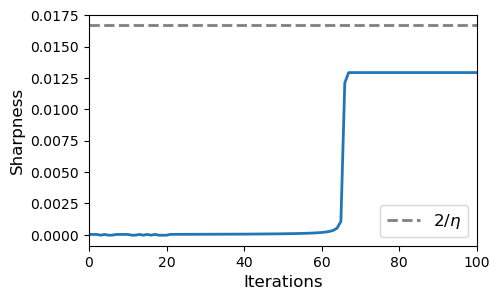

In [44]:
fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(111)
ax.plot(sharpness, linewidth=2,) # label=r'$\|\mathbf{W}_{3:1}(t) - \mathbf{M}^*\|^2_{\mathsf{F}}$')
#ax.semilogy(gd_result_smallest['test_loss'], color='red', linewidth=3, label=rf'GD $(\alpha = 0.001)$')
#ax.semilogy(label_noise_result['test_loss'], color='orange', linewidth=5, label=rf'Label Noise SGD $(\alpha = 0.1)$')
ax.set_xlabel(rf'Iterations', fontsize=12)
ax.set_ylabel('Sharpness', fontsize=12)
ax.hlines(y=0.0167, xmin=0, xmax=1000, color='gray', linestyles='dashed', linewidth=2, label=r'$2/\eta$')

ax.legend(fontsize=12, loc='lower right')
ax.set_xlim(0, 100)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('eos_nuance.pdf', bbox_inches='tight', pad_inches=0)



In [ ]:
sharpness[-1]

tensor(0.0129)